In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt

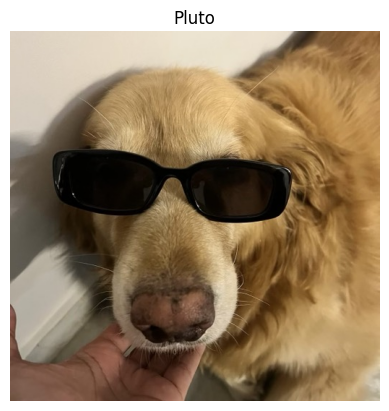

/Users/aman/Developer/ngp/env/lib/python3.9/site-packages/torch/functional.py:512: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:3588.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [2]:
image_path = 'pluto.png'  
image = Image.open(image_path).convert('RGB')
plt.imshow(image)
plt.axis('off')  
plt.title('Pluto')
plt.show()

transform = transforms.ToTensor()
img_tensor = transform(image).permute(1, 2, 0).view(-1, 3)  


h, w = image.size
y_coords = torch.linspace(-1, 1, steps=h)
x_coords = torch.linspace(-1, 1, steps=w)
yy, xx = torch.meshgrid(y_coords, x_coords)
coords = torch.stack([xx, yy], dim=-1).view(-1, 2)  # Shape: [N, 2]


dataset = TensorDataset(coords, img_tensor)
batch_size = 1024
data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

device = torch.device("mps")
num_epochs = 100

In [3]:
def train_and_plot(data_loader,model,criterion,optimizer,num_epochs,title):
    losses = []
    for epoch in range(num_epochs):
        for batch_coords, batch_img in data_loader:

            batch_coords = batch_coords.to(device)
            batch_img = batch_img.to(device)

            output = model(batch_coords)
            loss = criterion(output, batch_img)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            losses.append(loss.item())

        if(loss.item() < 0.0015):
            print(f"Loss below 0.0015, Trainig stopped at Epoch {epoch + 1} ")
            break
        
        if(epoch % 10 == 0):
            print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")

    plt.plot(losses)
    plt.xlabel('Batch')
    plt.ylabel('Loss')
    plt.title('Training Loss')
    plt.show()

    with torch.no_grad():
        output = model(coords.to(device))


    output_image = output.cpu().detach().reshape(h, w, 3).numpy()
    plt.imshow(output_image)
    plt.axis('off')  
    plt.title(title)
    plt.show()

In [4]:
class NeuralFields(nn.Module):
    def __init__(self):
        super(NeuralFields, self).__init__()
        self.fc1 = nn.Linear(2, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, 128)
        self.fc4 = nn.Linear(128, 3)
        self.relu = nn.ReLU()
        
    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.relu(self.fc3(x))
        x = self.fc4(x)  
        return x

Epoch [1/100], Loss: 0.0168
Epoch [11/100], Loss: 0.0043
Epoch [21/100], Loss: 0.0028
Epoch [31/100], Loss: 0.0029
Epoch [41/100], Loss: 0.0021
Epoch [51/100], Loss: 0.0024
Epoch [61/100], Loss: 0.0021
Epoch [71/100], Loss: 0.0019
Epoch [81/100], Loss: 0.0016
Epoch [91/100], Loss: 0.0027


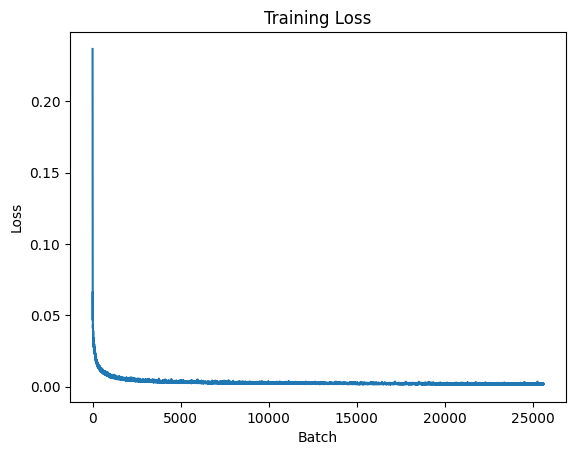

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.074837156..0.98735106].


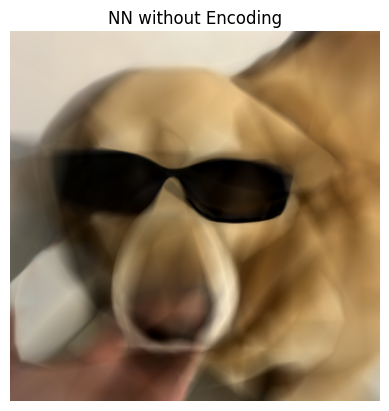

In [5]:
model = NeuralFields().to(device)


criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop

train_and_plot(data_loader,model,criterion,optimizer,num_epochs,"NN without Encoding")

In [6]:
class Sigmoid_Neural_Fields(NeuralFields):
    def __init__(self):
        super(Sigmoid_Neural_Fields,self).__init__()
        self.sig = nn.Sigmoid()      

    def forward(self,x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.relu(self.fc3(x))
        x = self.sig(self.fc4(x))
        return x
    
model = Sigmoid_Neural_Fields().to(device)    

Epoch [1/100], Loss: 0.0144
Epoch [11/100], Loss: 0.0046
Epoch [21/100], Loss: 0.0036
Epoch [31/100], Loss: 0.0031
Epoch [41/100], Loss: 0.0034
Epoch [51/100], Loss: 0.0030
Epoch [61/100], Loss: 0.0028
Epoch [71/100], Loss: 0.0029
Epoch [81/100], Loss: 0.0037
Epoch [91/100], Loss: 0.0024


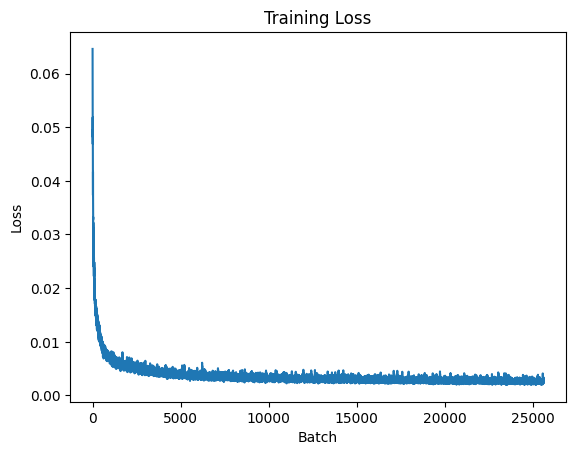

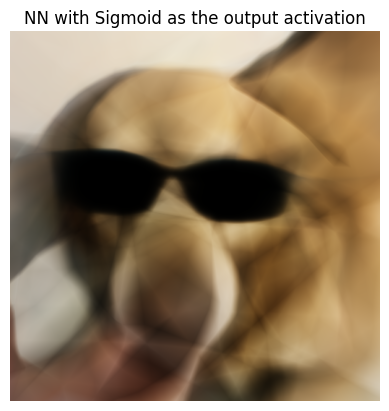

In [7]:
model = Sigmoid_Neural_Fields().to(device)


criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


train_and_plot(data_loader,model,criterion,optimizer,num_epochs,"NN with Sigmoid as the output activation")

In [8]:
def sinusoid(x):
    return torch.sin(2*torch.pi*x)

class Sinusoids_Neural_Fields(Sigmoid_Neural_Fields):
    def __init__(self):
        super(Sinusoids_Neural_Fields,self).__init__()

    def forward(self,x):
        x = sinusoid(self.fc1(x))
        x = sinusoid(self.fc2(x))
        x = sinusoid(self.fc3(x))
        x = self.fc4(x)
        return x

Epoch [1/100], Loss: 0.0027
Epoch [11/100], Loss: 0.0018
Loss below 0.0015, Trainig stopped at Epoch 19 


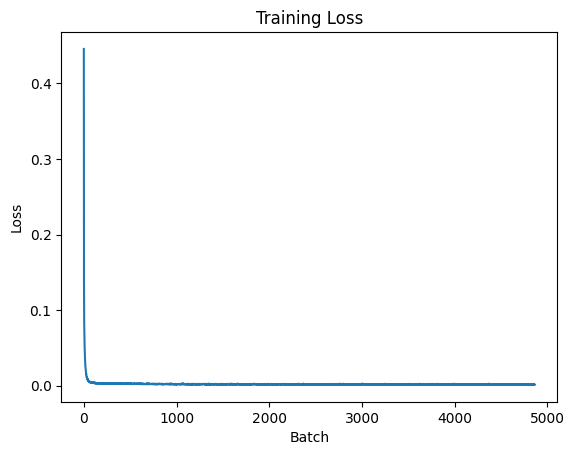

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.08044435..0.96313095].


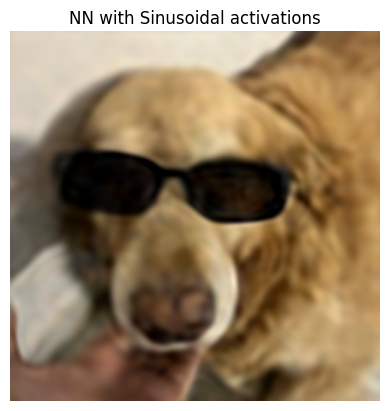

In [9]:
model = Sinusoids_Neural_Fields().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
losses = []
train_and_plot(data_loader,model,criterion,optimizer,num_epochs,"NN with Sinusoidal activations")

In [10]:
def custom_weight_init(m, omega_0=1.0):
    if isinstance(m, nn.Linear):
        fan_in = m.weight.size(1)
        bound = 1 / omega_0 * (6 / fan_in) ** 0.5
        nn.init.uniform_(m.weight, -bound, bound)

class Sinusoids_Neural_Fields_with_uniform_weight_distribution(Sigmoid_Neural_Fields):
    def __init__(self):
        super(Sinusoids_Neural_Fields_with_uniform_weight_distribution,self).__init__()
        self.apply(lambda m: custom_weight_init(m))

    def forward(self,x):
        x = sinusoid(self.fc1(x))
        x = sinusoid(self.fc2(x))
        x = sinusoid(self.fc3(x))
        x = self.fc4(x)
        return x

Epoch [1/100], Loss: 0.1025
Epoch [11/100], Loss: 0.0288
Epoch [21/100], Loss: 0.0275
Epoch [31/100], Loss: 0.0193
Epoch [41/100], Loss: 0.0125
Epoch [51/100], Loss: 0.0098
Epoch [61/100], Loss: 0.0071
Epoch [71/100], Loss: 0.0047
Epoch [81/100], Loss: 0.0033
Epoch [91/100], Loss: 0.0024
Loss below 0.0015, Trainig stopped at Epoch 100 


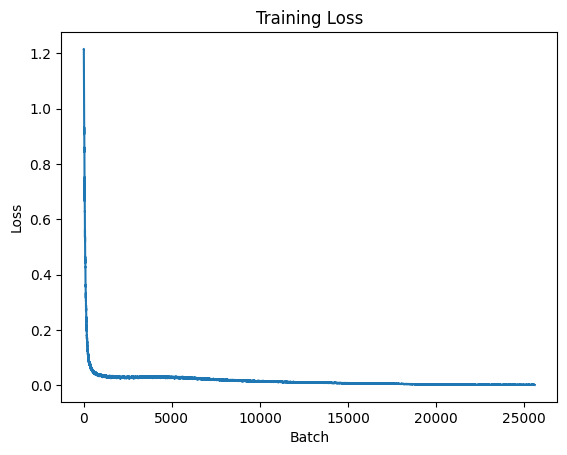

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.11490819..1.031992].


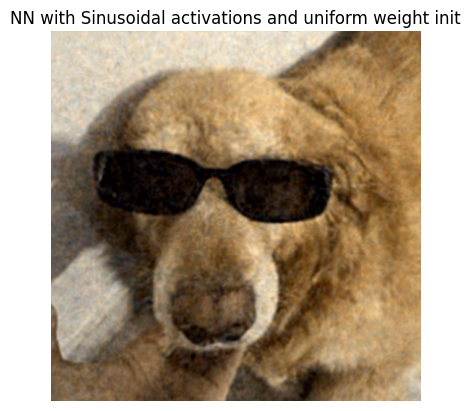

In [11]:
model = Sinusoids_Neural_Fields_with_uniform_weight_distribution().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
num_epochs = 100
train_and_plot(data_loader,model,criterion,optimizer,num_epochs,"NN with Sinusoidal activations and uniform weight init")

In [12]:
def positional_encoding(x, num_encoding_functions=6):
    encoding = [x]
    for i in range(num_encoding_functions):
        for func in [torch.sin, torch.cos]:
            encoding.append(func((2.0 ** i) * x))
    return torch.cat(encoding, dim=-1)

class NeuralFieldsWithPositionalEncoding(nn.Module):
    def __init__(self, input_dim=2, hidden_dim=128, output_dim=3, num_encoding_functions=6):
        super(NeuralFieldsWithPositionalEncoding, self).__init__()
        self.num_encoding_functions = num_encoding_functions
        encoded_dim = input_dim * (2 * num_encoding_functions + 1)
        self.fc1 = nn.Linear(encoded_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, hidden_dim)
        self.fc4 = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x = positional_encoding(x, self.num_encoding_functions)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = self.fc4(x)
        return x

Epoch [1/100], Loss: 0.0038
Loss below 0.0015, Trainig stopped at Epoch 5 


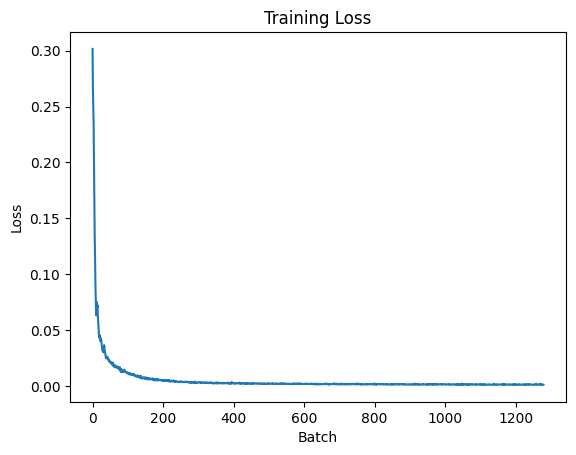

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.03870281..1.0049704].


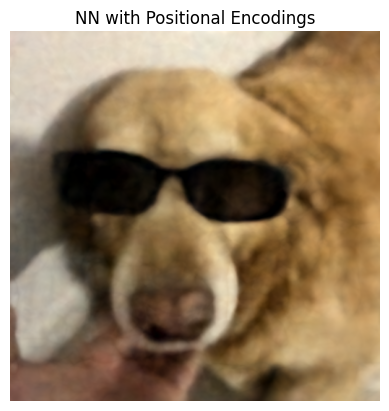

In [13]:
model = NeuralFieldsWithPositionalEncoding().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

losses = []
train_and_plot(data_loader,model,criterion,optimizer,num_epochs,"NN with Positional Encodings")

In [14]:
class HashEncoding(nn.Module):
    def __init__(self, num_levels, level_dim, min_resolution, max_resolution, input_dim=2):
        super(HashEncoding, self).__init__()
        self.num_levels = num_levels
        self.level_dim = level_dim
        self.min_resolution = min_resolution
        self.max_resolution = max_resolution
        self.input_dim = input_dim

        self.hash_tables = nn.ModuleList([
            nn.Embedding(self.max_resolution ** self.input_dim, self.level_dim)
            for _ in range(self.num_levels)
        ])
        for table in self.hash_tables:
            nn.init.uniform_(table.weight, -1e-4, 1e-4)

    def forward(self, coords):
        embeddings = []
        
        for level, table in enumerate(self.hash_tables):
            resolution = int(self.min_resolution * (self.max_resolution / self.min_resolution) ** (level / (self.num_levels - 1)))
            coords_scaled = (coords * resolution).long() % resolution
            indices = coords_scaled[:, 0] * resolution + coords_scaled[:, 1]
            embeddings.append(table(indices))
        return torch.cat(embeddings, dim=-1)

In [15]:
class NeuralFieldsWithHashEncoding(nn.Module):
    def __init__(self, num_levels, level_dim, min_resolution, max_resolution, input_dim=2, hidden_dim=128, output_dim=3):
        super(NeuralFieldsWithHashEncoding, self).__init__()
        self.hash_encoding = HashEncoding(num_levels, level_dim, min_resolution, max_resolution, input_dim)
        self.fc1 = nn.Linear(num_levels * level_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, hidden_dim)
        self.fc4 = nn.Linear(hidden_dim, output_dim)

    def forward(self, coords):
        x = self.hash_encoding(coords)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = self.fc4(x)
        return x

Epoch [1/100], Loss: 0.0328
Epoch [11/100], Loss: 0.0022
Loss below 0.0015, Trainig stopped at Epoch 14 


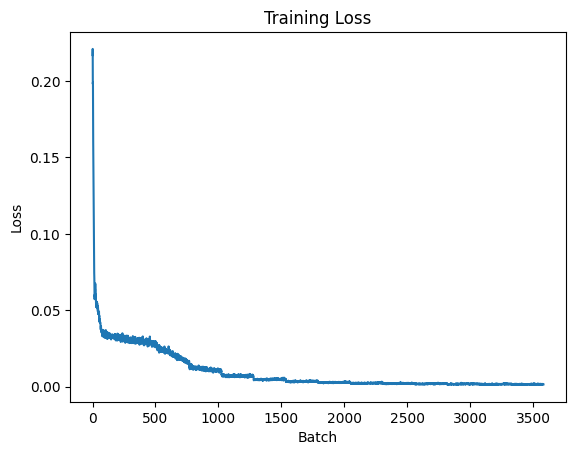

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.06862129..0.96970564].


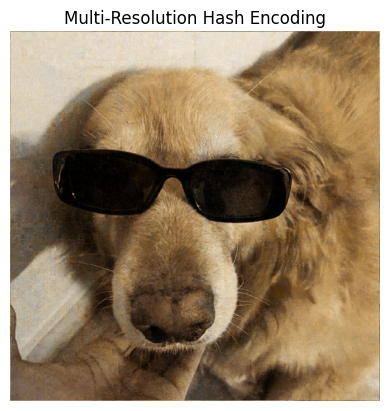

In [16]:
num_levels = 16
level_dim = 2
min_resolution = 16
max_resolution = 512
hidden_dim = 128



model = NeuralFieldsWithHashEncoding(num_levels, level_dim, min_resolution, max_resolution, hidden_dim=hidden_dim).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


train_and_plot(data_loader, model, criterion, optimizer, num_epochs,"Multi-Resolution Hash Encoding")